In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import ToTensor, Normalize, Compose

In [2]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

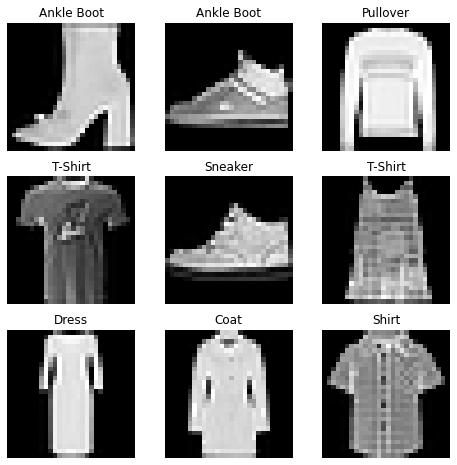

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [4]:
# Normalize(mean=(0.5,), std=(0.5,))

Label:  9


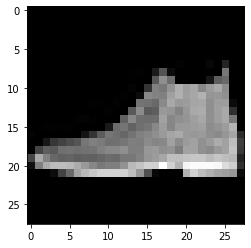

In [5]:
img, label = test_data[0]
plt.imshow(img[0], cmap='gray')
print('Label: ',label)

In [6]:
from torch.utils.data import DataLoader
batch_size = 100
data_loader = DataLoader(train_data, batch_size, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
latent_size = 64
hidden_size = 256
image_size = 784

In [7]:
class Discriminator(nn.Module):
  # __init__ is known as constructor in Python
  def __init__(self):
    super(Discriminator, self).__init__()
    self.D = nn.Sequential(
        nn.Linear(image_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, 1),
        nn.Sigmoid()
    )
  def forward(self,x):
    return self.D(x)

In [8]:
D = Discriminator()

In [9]:
class Generator(nn.Module):
  # __init__ is known as the constructor in Python
  def __init__(self):
    super(Generator, self).__init__()
    self.G = nn.Sequential(
        nn.Linear(latent_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, image_size),
        nn.Tanh())
  def forward(self,x):
    return self.G(x)

In [10]:
G = Generator()

In [11]:
def create_image():
  y = torch.randn(batch_size,latent_size)
  return y

In [12]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [13]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

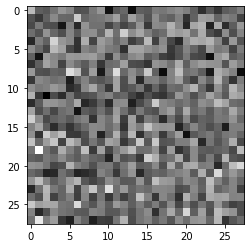

In [14]:
plt.imshow(gen_imgs[0], cmap='gray');

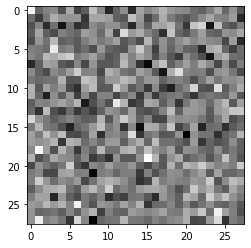

In [15]:
plt.imshow(gen_imgs[1], cmap='gray');

In [16]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr = 0.0001)
g_optimizer = torch.optim.Adam(G.parameters(), lr = 0.0001)

In [23]:
def reset_grad():
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()

def train_discriminator(images):
  real_ones = torch.ones(batch_size,1)
  false_ones = torch.zeros(batch_size, 1)

  # Loss for real images
  outputs = D(images)
  d_loss_real = criterion(outputs, real_ones)
  real_score = outputs

  # Loss for fake images
  z = torch.randn(batch_size, latent_size)
  fake_images = G(z)
  outputs = D(fake_images)
  d_loss_fake = criterion(outputs, false_ones)
  fake_score = outputs

  # Combine Losses
  d_loss = d_loss_real + d_loss_fake
  # Reset gradients
  reset_grad()
  # Compute gradients
  d_loss.backward()
  # Adjust the parameters using backprop
  d_optimizer.step()

  return d_loss, real_score, fake_score

In [24]:
def train_generator():
  images = torch.randn(batch_size, latent_size)
  fake_images = G(images)
  labels = torch.ones(batch_size,1)
  g_loss = criterion(D(fake_images), labels)

  # Backprop and optimize
  reset_grad()
  g_loss.backward()
  g_optimizer.step()

  return g_loss, fake_images

In [25]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

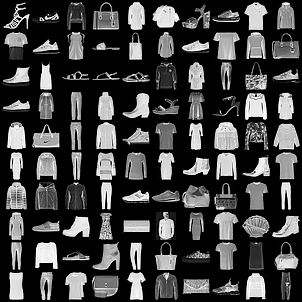

In [26]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


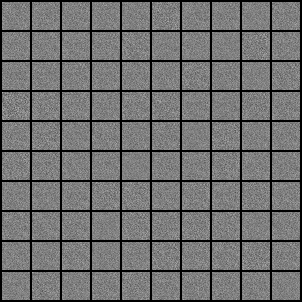

In [27]:
sample_vectors = torch.randn(batch_size, latent_size)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [28]:

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
for epoch in range(num_epochs):
  for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
  # Sample and save images
  save_fake_images(epoch+1)


Epoch [0/300], Step [200/600], d_loss: 0.4262, g_loss: 1.8415, D(x): 0.89, D(G(z)): 0.26
Epoch [0/300], Step [400/600], d_loss: 0.2253, g_loss: 2.6859, D(x): 0.90, D(G(z)): 0.11
Epoch [0/300], Step [600/600], d_loss: 0.1011, g_loss: 3.5757, D(x): 0.97, D(G(z)): 0.07
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.1003, g_loss: 3.4919, D(x): 0.96, D(G(z)): 0.05
Epoch [1/300], Step [400/600], d_loss: 0.1068, g_loss: 3.8487, D(x): 0.96, D(G(z)): 0.06
Epoch [1/300], Step [600/600], d_loss: 0.0555, g_loss: 4.1822, D(x): 0.98, D(G(z)): 0.03
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0941, g_loss: 3.7698, D(x): 0.97, D(G(z)): 0.05
Epoch [2/300], Step [400/600], d_loss: 0.0310, g_loss: 4.6036, D(x): 0.98, D(G(z)): 0.01
Epoch [2/300], Step [600/600], d_loss: 0.0204, g_loss: 5.1227, D(x): 0.99, D(G(z)): 0.01
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.0337, g_loss: 4.6024, D(x): 1.00, D(G(z)): 0.03
Epoch [3/300], Step [400/6

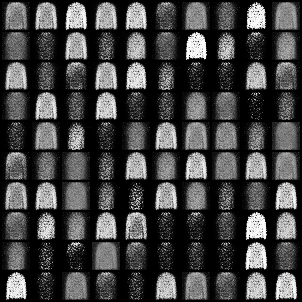

In [29]:
Image('./samples/fake_images-0010.png')

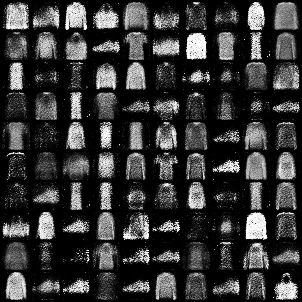

In [30]:
Image('./samples/fake_images-0050.png')

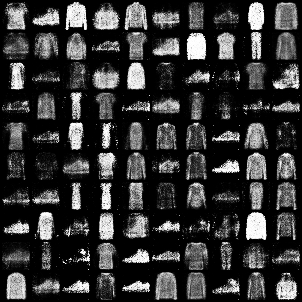

In [31]:
Image('./samples/fake_images-0100.png')

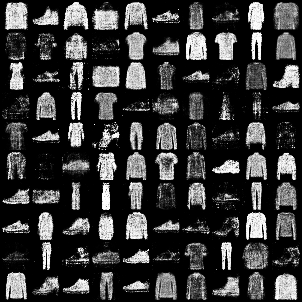

In [32]:
Image('./samples/fake_images-0300.png')

In [33]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/content/gans_training.avi

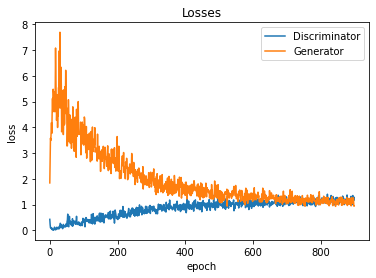

In [34]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

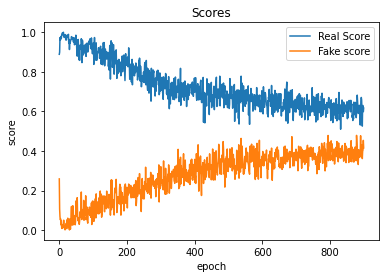

In [35]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');